In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('data/sepsis_final.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [2]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [3]:
import importlib
import medical_explainer_classic
importlib.reload(medical_explainer_classic)

explainer = medical_explainer_classic.explainer(
    X_train, y_train, X_test, y_test
)

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Select top 10 features for fair comparison
top_n = 10

scaler = MinMaxScaler()
select = SelectKBest(chi2, k=top_n)
select.fit(scaler.fit_transform(X_train), y_train)
selected_features = select.get_feature_names_out(X_train.columns)


In [5]:
from pygam import LogisticGAM, s, f

equation = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9)

gam = LogisticGAM(equation).fit(X_train[selected_features], y_train)

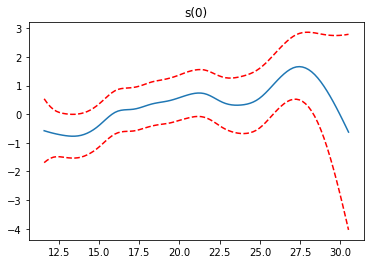

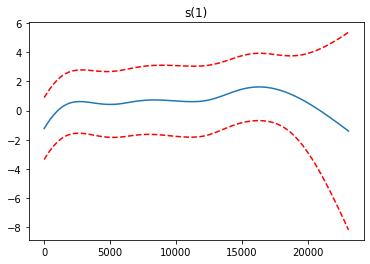

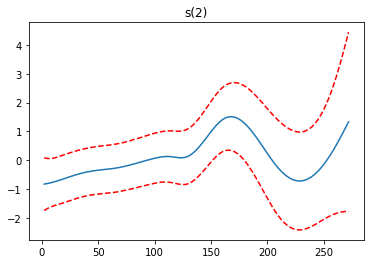

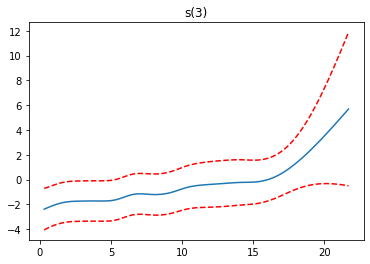

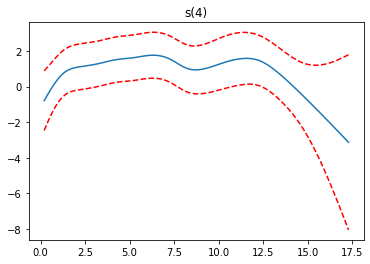

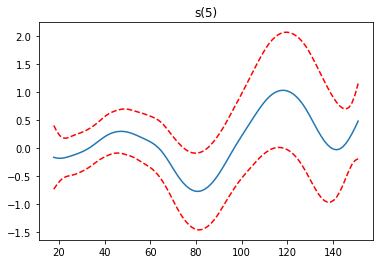

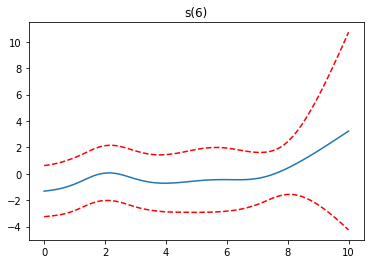

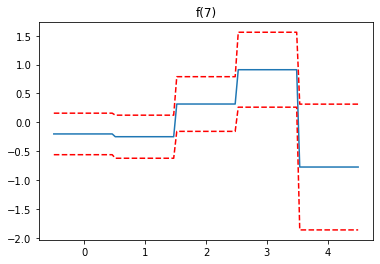

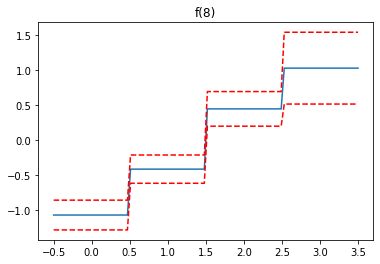

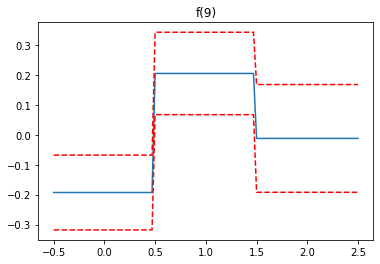

In [6]:
import matplotlib.pyplot as plt


for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [7]:
import importlib
import medical_explainer_classic
importlib.reload(medical_explainer_classic)

explainer = medical_explainer_classic.explainer(
    X_train, y_train, X_test, y_test
)

| Step 1 ==> Selecting top n features
| Step 2 ==> Transforming features based on GAM
| Step 3 ==> Fitting logistic regression model on transformed categories
| Step 4 ==> Calibrating logistic regression model


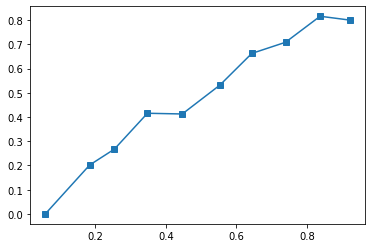

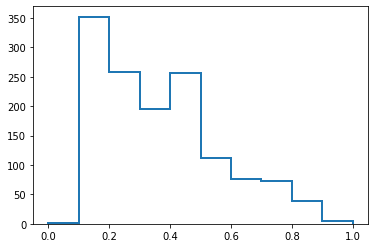

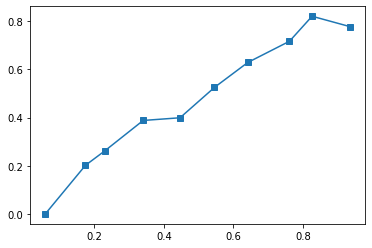

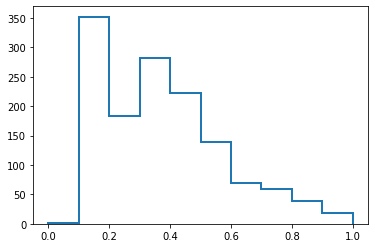

| Step 5 ==> Fit clinical score calculator
Fit clincal score calculator
Threshold:0.1
31

Threshold:0.5
38

Threshold:0.9
44



In [8]:
from sklearn.model_selection import StratifiedKFold

print('| Step 1 ==> Selecting top n features')
explainer.selected_features = selected_features

print('| Step 2 ==> Transforming features based on GAM')
explainer.find_features_categories_gam(equation)

print('| Step 3 ==> Fitting logistic regression model on transformed categories')
explainer.fit_logreg()

print('| Step 4 ==> Calibrating logistic regression model')

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

explainer.plot_calibration_original()
explainer.calibrate(cv=skf)
explainer.plot_calibration_calibrated()

print('| Step 5 ==> Fit clinical score calculator')
explainer.fit_calculator()

In [17]:
explainer.scores

array([4., 7., 3., 3., 7., 3., 4., 6., 3., 5., 2., 3., 7., 4., 3., 4., 4.,
       6., 3., 6., 2., 6., 4., 5., 5., 6., 3., 0., 4., 5., 5.])

In [18]:
explainer.selected_features

array(['RDW', 'Lactate Dehydrogenase (LD)', 'Urea Nitrogen', 'Lactate',
       'Phosphate', 'PTT', 'Yeast', 'antifungals', 'inotropes',
       'immunosuppresant'], dtype=object)

In [19]:
explainer.breakpoints_list

[[11.6, 15.81718439775919, 29.954851509977345, 30.5],
 [-8.271937990619335, 1034.3945982586456, 20933.26957391865, 23111.0],
 [2.0, 93.37063601905183, 204.21713099895004, 252.7562793555326, 272.0],
 [0.3, 16.041045332445407, 21.7],
 [0.2, 0.6737203534302818, 14.209047612313842, 17.3],
 [17.7,
  33.1392142656212,
  63.61527897675297,
  96.72046112512066,
  139.34346152094727,
  143.5245295310544,
  151.0],
 [0.0, 1.8547274419228266, 2.416891938935314, 7.565204379149908, 10.0],
 [-0.5, 1.4919880277004824, 3.517180914277105, 4.5],
 [-0.5, 1.4991346844143676, 3.5],
 [-0.5, 0.48438751039853845, 1.4983103349353974, 2.5]]

In [20]:
explainer.beta_values

array([-0.03016593,  0.83686916, -0.17129872, -0.19421439,  1.01916978,
       -0.18955088, -0.1007121 ,  0.74036306, -0.4427326 ,  0.43848615,
       -0.68598817, -0.32078062,  0.88722252,  0.06896261, -0.21948365,
        0.16016474,  0.01882202,  0.51457355, -0.32749717,  0.48882502,
       -0.69634818,  0.8005838 ,  0.09442472,  0.43674418,  0.1863266 ,
        0.79564804, -0.34657013, -1.23417432, -0.03694975,  0.46682956,
        0.20552469])

In [21]:
scores, probs, predictions = explainer.predict_calculator(X_test, threshold_choice=1)

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.6701822786874847
Average Precision: 0.5362202116914832
Accuracy: 0.6459400146305779
[[641 203]
 [281 242]]
